In [181]:
# Packages
import numpy as np
import matplotlib.pyplot as plt

In [182]:
def restriction(full_grid):
    N = (full_grid.shape[0] - 2) // 2  # New coarse size
    coarse_grid = np.zeros((N + 2, N + 2))
    
    # Select inner points to be calculated
    ii = np.arange(2, 2*N + 2, 2)
    jj = ii[:, np.newaxis]

    # Calculate weighted average contributions
    central = full_grid[ii, jj] * 0.25
    horizontal = (full_grid[ii+1, jj] + full_grid[ii-1, jj]) * 0.125
    vertical = (full_grid[ii, jj+1] + full_grid[ii, jj-1]) * 0.125
    diagonal = (full_grid[ii+1, jj+1] + full_grid[ii-1, jj-1] + full_grid[ii-1, jj+1] + full_grid[ii+1, jj-1]) * 0.0625

    # Sum all contributions
    coarse_grid[1:N+1, 1:N+1] = central + horizontal + vertical + diagonal

    return coarse_grid

def prolongation(coarse_grid):
    N = (coarse_grid.shape[0] - 2)  # Coarse grid inner points
    fine_N = 2 * N  # Fine grid inner points
    fine_grid = np.zeros((fine_N + 2, fine_N + 2))
    
    # Define indices for accessing coarse grid points
    i = np.arange(1, N+1)
    j = i[:, np.newaxis]

    ii = 2 * i
    jj = 2 * j

    # Direct assignments
    fine_grid[ii-1, jj-1] = coarse_grid[i, j]
    
    # Interpolations along axes
    fine_grid[ii, jj-1] = 0.5 * (coarse_grid[i, j] + coarse_grid[np.minimum(i+1, N), j])
    fine_grid[ii-1, jj] = 0.5 * (coarse_grid[i, j] + coarse_grid[i, np.minimum(j+1, N)])

    # Diagonal interpolation
    fine_grid[ii, jj] = 0.25 * (coarse_grid[i, j] + coarse_grid[np.minimum(i+1, N), j] +
                                coarse_grid[i, np.minimum(j+1, N)] + coarse_grid[np.minimum(i+1, N), np.minimum(j+1, N)])

    return fine_grid

In [183]:
def initialize_poisson_problem(N):
    # Grid spacing
    h = 1.0 / (N + 1)
    x = np.linspace(0, 1, N+2)  # include boundary points
    y = np.linspace(0, 1, N+2)  # include boundary points
    
    # Initialize solution and RHS arrays
    u = np.zeros((N+2, N+2))  # include boundary values, initialized to zero
    f = np.zeros((N+2, N+2))
    
    # Use outer product for right-hand side f(x, y)
    X, Y = np.meshgrid(x, y, indexing='ij')
    f[1:N+1, 1:N+1] = -2 * (np.pi**2) * np.sin(np.pi * X[1:N+1, 1:N+1]) * np.sin(np.pi * Y[1:N+1, 1:N+1])
    
    return u, f, h

In [184]:
def compute_analytical_solution(x, y):
    # Create a meshgrid for the x and y arrays
    X, Y = np.meshgrid(x, y, indexing='ij')

    # Compute the analytical solution on the grid using vectorized operations
    u_exact = np.sin(np.pi * X) * np.sin(np.pi * Y)

    return u_exact

In [185]:
def gauss_seidel_smoothing(u, f, h, num_iterations):
    N = u.shape[0] - 2  # Exclude boundary points
    for _ in range(num_iterations):
        for i in range(1, N+1):
            for j in range(1, N+1):
                u[i, j] = 0.25 * (u[i+1, j] + u[i-1, j] + u[i, j+1] + u[i, j-1] - h**2 * f[i, j])
    return u

def compute_residual(u, f, h):
    N = u.shape[0] - 2
    r = np.zeros_like(u)
    
    # Vectorize the Laplacian calculation except at the boundaries
    laplacian_u = (u[2:N+2, 1:N+1] + u[0:N, 1:N+1] + 
                   u[1:N+1, 2:N+2] + u[1:N+1, 0:N] - 
                   4 * u[1:N+1, 1:N+1]) / h**2
                   
    r[1:N+1, 1:N+1] = f[1:N+1, 1:N+1] - laplacian_u
    
    return r

In [186]:
def v_cycle(u, f, h, iterations, max_levels, level):
    print(f"Level {level}: Grid size {u.shape}")
    if level == max_levels:
        # Direct solve at the coarsest level (simulated by multiple Gauss-Seidel iterations)
        return gauss_seidel_smoothing(u, f, h, iterations)
    else:
        
        # Step 1: Pre-smoothing
        u = gauss_seidel_smoothing(u, f, h, iterations)
        
        # Step 2: Compute residual and restrict
        residual = compute_residual(u, f, h)
        coarse_residual = restriction(residual)
        
        # Coarse grid solution (initially zero)
        coarse_u = np.zeros_like(coarse_residual)
        coarse_f = coarse_residual  # The right-hand side is the restricted residual
        h_coarse = 2 * h  # Coarse grid spacing
        
        # Step 3: Recursive call (simulate with one level deeper)
        coarse_correction = v_cycle(coarse_u, coarse_f, h_coarse, iterations, max_levels, level=level+1)
        
        # Step 4: Prolongate the correction and update fine grid solution
        fine_correction = prolongation(coarse_correction)
        u += fine_correction
        
        # Step 5: Post-smoothing
        u = gauss_seidel_smoothing(u, f, h, iterations)
        
        return u


In [187]:
def w_cycle(u, f, h, iterations, max_levels, level):
    print(f"Level {level}: Grid size {u.shape}")
    if level == max_levels:
        # Direct solve at the coarsest level (simulated by multiple Gauss-Seidel iterations)
        return gauss_seidel_smoothing(u, f, h, iterations)
    else:
        # Step 1: Pre-smoothing
        u = gauss_seidel_smoothing(u, f, h, iterations)
        
        # Step 2: Compute residual and restrict
        residual = compute_residual(u, f, h)
        coarse_residual = restriction(residual)
        
        # Coarse grid solution (initially zero)
        coarse_u = np.zeros_like(coarse_residual)
        coarse_f = coarse_residual  # The right-hand side is the restricted residual
        h_coarse = 2 * h  # Coarse grid spacing
        
        # Step 3: First recursive call (W-cycle first visit)
        coarse_correction = w_cycle(coarse_u, coarse_f, h_coarse, iterations, max_levels, level=level+1)
        
        # Update coarse grid solution with the correction
        coarse_u += coarse_correction
        
        # Step 4: Second recursive call (W-cycle second visit)
        coarse_correction = w_cycle(coarse_u, coarse_f, h_coarse, iterations, max_levels, level=level+1)
        
        # Step 5: Prolongate the correction and update fine grid solution
        fine_correction = prolongation(coarse_correction)
        u += fine_correction
        
        # Step 6: Post-smoothing
        u = gauss_seidel_smoothing(u, f, h, iterations)
        
        return u


In [188]:
# Parameters
grid_size = 256
iterations = 100

max_levels = 5

# Example: Initialize a grid
u_initial, f_initial, h_initial = initialize_poisson_problem(grid_size)

# Run the Gauss-Seidel solver
u_solved = v_cycle(u_initial, f_initial, h_initial, iterations, max_levels, 1)

# Compute the analytical solution
x = np.linspace(0, 1, u_solved.shape[0])
y = np.linspace(0, 1, u_solved.shape[0])
u_exact = compute_analytical_solution(x, y)

# Compute the error
l2_error = np.linalg.norm(u_solved - u_exact, 2)/(grid_size**2)

Level 1: Grid size (258, 258)
Level 2: Grid size (130, 130)
Level 3: Grid size (66, 66)
Level 4: Grid size (34, 34)
Level 5: Grid size (18, 18)


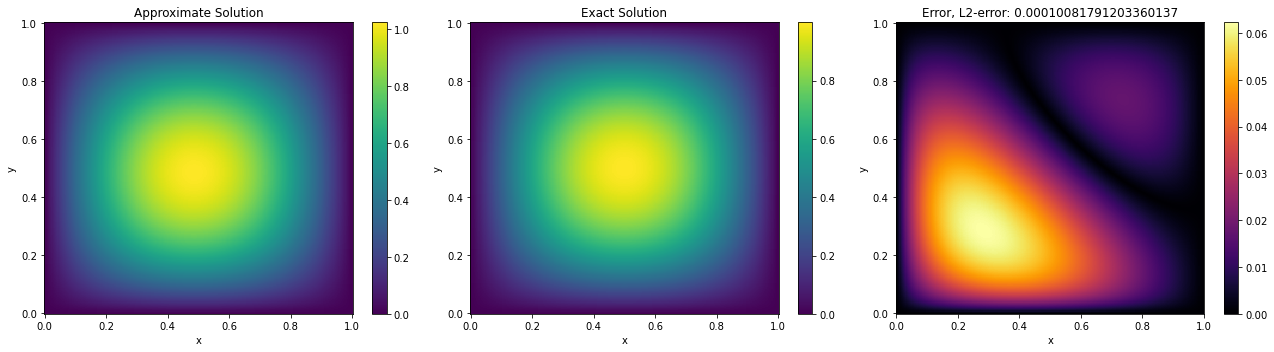

In [189]:
def plot_solutions(x, y, u_approx, u_exact):
    # Compute the error
    error = np.abs(u_approx - u_exact)
    
    # Prepare meshgrid for plotting
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    # Plotting
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
    
    # Approximate solution
    c1 = axes[0].pcolormesh(X, Y, u_approx, shading='auto', cmap='viridis')
    fig.colorbar(c1, ax=axes[0])
    axes[0].set_title('Approximate Solution')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    
    # Exact solution
    c2 = axes[1].pcolormesh(X, Y, u_exact, shading='auto', cmap='viridis')
    fig.colorbar(c2, ax=axes[1])
    axes[1].set_title('Exact Solution')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    
    # Error
    c3 = axes[2].pcolormesh(X, Y, error, shading='auto', cmap='inferno')
    fig.colorbar(c3, ax=axes[2])
    axes[2].set_title('Error, L2-error: ' + str(l2_error))
    axes[2].set_xlabel('x')
    axes[2].set_ylabel('y')

    plt.tight_layout()
    plt.show()

# Run the plotting function with our solutions
plot_solutions(x, y, u_solved, u_exact)
